In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.io

In [3]:
mat_contents = scipy.io.loadmat(os.path.join('allFaces.mat'))
faces = mat_contents['faces']
m = int(mat_contents['m'].squeeze())
n = int(mat_contents['n'].squeeze())
nfaces = np.ndarray.flatten(mat_contents['nfaces']).astype(int)

`PCA`

In [4]:
num_people = 38
images_per_person_train = 4
image_size = m * n
trainingFaces = faces[:,:np.sum(nfaces[:36])]
avgFace = np.mean(trainingFaces,axis=1)
training_images = []
labels = []

start_idx = 0
for person_id in range(num_people):
    num_images = nfaces[person_id]
    end_idx = start_idx + num_images

    person_images = faces[:, start_idx:end_idx]
    person_train = person_images[:, :images_per_person_train]

    training_images.append(person_train)
    labels.extend([person_id] * images_per_person_train)

    start_idx = end_idx

# Build training matrix
trainingFaces = np.hstack(training_images)
labels = np.array(labels)
avgFace = np.mean(trainingFaces, axis=1)

# --- SVD ---
X = trainingFaces - avgFace[:, None]
U, S, VT = np.linalg.svd(X, full_matrices=False)

In [5]:
# --- Build face space ---
k = 50  # number of eigenfaces to keep
U_k = U[:, :k]

# --- Project training faces into eigenspace ---
train_weights = U_k.T @ (trainingFaces - avgFace[:, None])  # shape: (k, num_train_images)

# --- Define distance threshold statistically from training set ---
# Compute all pairwise distances between training images of same person
intra_class_dists = []
for i in range(len(labels)):
    for j in range(i+1, len(labels)):
        if labels[i] == labels[j]:
            dist = np.linalg.norm(train_weights[:, i] - train_weights[:, j])
            intra_class_dists.append(dist)

intra_class_dists = np.array(intra_class_dists)
THRESHOLD = np.percentile(intra_class_dists, 95)  # you can tune this (e.g. 95%)

print(f"Distance threshold set to: {THRESHOLD:.2f}")

# --- Recognition function ---
def recognize(query_img_flat):
    phi = query_img_flat - avgFace
    wq = U_k.T @ phi
    dists = np.linalg.norm(train_weights - wq[:, None], axis=0)
    i_best = np.argmin(dists)
    if dists[i_best] > THRESHOLD:
        return "unknown"
    return labels[i_best]

Distance threshold set to: 22223.82


In [6]:
# for i in range(38) : 
    # for j in range(64) : print(f'{j},{recognize(faces[:, np.sum(nfaces[:i]) + j])}'  ,end=' ')
    # print ('\n')

# Testing with one unseen image per person
query_faces = []
query_labels = []

start_idx = 0
for person_id in range(num_people):
    num_images = nfaces[person_id]
    end_idx = start_idx + num_images
    person_images = faces[:, start_idx:end_idx]

    if num_images > images_per_person_train:
        query_faces.append(person_images[:, images_per_person_train])
        query_labels.append(person_id)

    start_idx = end_idx

correct = 0
for i, query_face in enumerate(query_faces):
    pred = recognize(query_face)
    if pred == query_labels[i]:
        correct += 1
    print(f"True: {query_labels[i]}, Predicted: {pred}")

print(f"\nAccuracy: {100*correct/len(query_faces):.2f}%")


True: 0, Predicted: 0
True: 1, Predicted: 1
True: 2, Predicted: 2
True: 3, Predicted: 3
True: 4, Predicted: 4
True: 5, Predicted: 5
True: 6, Predicted: 6
True: 7, Predicted: 7
True: 8, Predicted: 8
True: 9, Predicted: 9
True: 10, Predicted: 10
True: 11, Predicted: 11
True: 12, Predicted: 12
True: 13, Predicted: 13
True: 14, Predicted: 14
True: 15, Predicted: 15
True: 16, Predicted: 16
True: 17, Predicted: 17
True: 18, Predicted: 18
True: 19, Predicted: 19
True: 20, Predicted: 20
True: 21, Predicted: 21
True: 22, Predicted: 22
True: 23, Predicted: 23
True: 24, Predicted: 24
True: 25, Predicted: 25
True: 26, Predicted: 26
True: 27, Predicted: 27
True: 28, Predicted: 28
True: 29, Predicted: 29
True: 30, Predicted: 30
True: 31, Predicted: 31
True: 32, Predicted: 32
True: 33, Predicted: 33
True: 34, Predicted: 34
True: 35, Predicted: 35
True: 36, Predicted: 36
True: 37, Predicted: 37

Accuracy: 100.00%


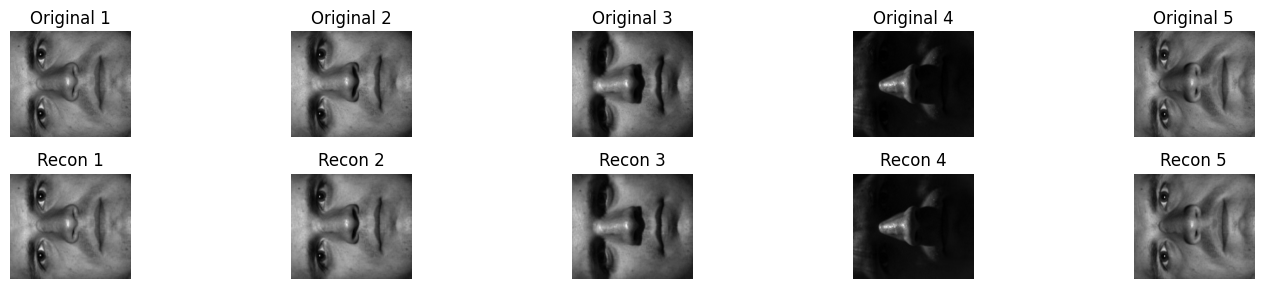

In [ ]:
# --- Parameters ---
person_id = 3  # change this to choose a different person
num_images_to_show = 5
beta = m / n

# --- Approximate ω(β) as given in Equation (5) ---
omega = 0.56 * beta**3 - 0.95 * beta**2 + 1.82 * beta + 1.43

# --- Get person images ---
start_idx = np.sum(nfaces[:person_id])
end_idx = start_idx + nfaces[person_id]
person_images = faces[:, start_idx:end_idx][:, :num_images_to_show]

# --- Display original images ---
plt.figure(figsize=(15, 3))
for i in range(num_images_to_show):
    img = person_images[:, i].reshape(m, n)
    plt.subplot(2, num_images_to_show, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(f'Original {i+1}')

# --- Reconstruct images using SVD with τ* threshold ---
for i in range(num_images_to_show):
    
    t_star = omega * avgface

    # Keep only singular values > t_star
    S_thresh = np.diag([s if s > t_star else 0 for s in S_img])
    reconstructed = U_img @ S_thresh @ Vt_img

    # Show reconstructed image
    plt.subplot(2, num_images_to_show, i + 1 + num_images_to_show)
    plt.imshow(reconstructed, cmap='gray')
    plt.axis('off')
    plt.title(f'Recon {i+1}')

plt.tight_layout()
plt.show()
